# Proton Radiography: Creating Synthetic Proton Radiographs by Particle Tracing

Proton radiography is an diagnostic technique often used to interrogate the electric and magnetic fields inside high energy density plasmas. The area of interest is positioned between a bright source of protons and a detector plane. Electric and magnetic fields in the plasma deflect the protons, producing patterns on the detector. Since this represents a non-linear and line-integrated measurement of the fields, the interpretation of these "proton radiographs" is complicated.

The SimPrad module contains tools to create synthetic proton radiographs given a grid of electric and magnetic field from either calculations or simulations. After the geometry of the problem has been set up during initialization, a particle tracing algorithm is run, tracking the positions of up to several million protons as they pass through the fields region. After all particles have reached the detector plane, a synthetic proton radiograph can be made by creating a 2D histogram in that plane.

In [5]:
import astropy.constants as const
import astropy.units as u
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from plasmapy.diagnostics import proton_radiography as prad

Several examples of 3D grid of fields are included in the package. This example contains the radial electric field created by a Gaussian sphere of electric charge.

Text(0.5, 0.92, 'Gaussian Potential Electric Field')

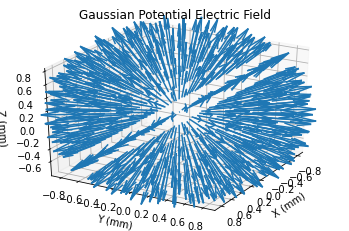

In [6]:
grid, E, B = prad.example_fields(model='electrostatic gaussian sphere', emax=8e8*u.V/u.m,
                             num=(200,200,200))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.view_init(30,30)

s = slice(None,None,20) # Plot only every 6th point
ax.quiver(grid[s,s,s,0].to(u.mm).value, grid[s,s,s,1].to(u.mm).value,  grid[s,s,s,2].to(u.mm).value,
           E[s,s,s,0].value, E[s,s,s,1].value, E[s,s,s,2].value, length=1e-9)

ax.set_xlabel("X (mm)")
ax.set_ylabel("Y (mm)")
ax.set_zlabel("Z (mm)")
ax.set_title("Gaussian Potential Electric Field")

Prior to running the particle tracing algorithm, the simulation instance must be instatiated by providing some information about the setup, including:
- The location of the proton souce with respect to the origin of the field grid. Only point sources are supported. 
    
- The location of the center of the detector plane. The vector from this point to the origin of the field grid defines the normal vector of the detector plane. The horizontal axis of the detector plane is defined to be orthoganal to the z-axis of the field grid.
    
- The energy of the protons. Lower energy protons will undergo more severe deflections.
    
The source and detector coordinates are entered as a 3-tuple in one of three coordinate systems: cartesian (x,y,z), spherical (r, theta, phi) or cylindrical (r, theta, z). All values should be astropy Quantities with units of either length or angle (degrees or radians) as appropriate. Note that the vector from the source to the detector should pass through the origin to maximize the number of particles that pass through the simulated fields.

In [7]:
source = (0*u.mm,-10*u.mm, 0*u.mm)
detector = (0*u.mm, 100*u.mm, 0*u.mm) 

sim = prad.SyntheticProtonRadiograph(grid, E, B, source, detector, 
                   proton_energy=14*u.MeV, geometry='cartesian')

Source: [  0. -10.   0.] mm
Detector: [  0. 100.   0.] mm


In order to run the simulation, a number of simulated particles must be selected (nparticles). The simulation timestep is automatically (and adaptively) calculated based on the proton energy, grid resolution, and field amplitudes. Since particles generated at extreme angles will likely never hit the detector, setting the parameter 'max_theta' to an angle less than $\pi/2$ allows for a more efficient calculation.

In brief, the steps of the simulation cycle are as follows:

1. Particle velocities are initialized with a uniform distribution per solid angle. Distributions are generated about the z-axis, then rotated to be parallel to the source-to-detector vector.

2. Particles are advanced to the time when the first particle enters the simulation volume. This is done in one step to save otherwise useless computatations.

3. While particles are on the grid, the particle pusher advances them each timestep by executing the following steps:
    1. The nearest grid vertex to each particles is interpolated.
    2. The adaptive time step is computed based on the local grid resolution and fields for the particles.
    3. An implementation of the Boris particle push algorithm is used to advance the velocities and positions of the particles in the interpolated fields.
    
    
4. After all of the particles have left the grid, all particles are advanced to the detector plane (again saving useless computations). Particles that are headed away from the detector plane at this point are deleted, as those particles will never
be detected.


In [8]:
sim.run(nparticles=4e5, max_theta = np.pi/15*u.rad)

Auto-detected a regularly spaced grid.
Creating regular grid interpolator
Creating Particles
0.0% on grid (0.0)
0.0% on grid (5)
9.1% on grid (20283)
18.4% on grid (40849)
27.6% on grid (61430)
36.7% on grid (81541)
45.9% on grid (101967)
54.0% on grid (119982)
58.4% on grid (129855)
61.1% on grid (135717)
62.7% on grid (139372)
63.5% on grid (141155)
63.7% on grid (141455)
63.5% on grid (141131)
63.4% on grid (140793)
63.2% on grid (140483)
63.1% on grid (140194)
63.0% on grid (139880)
62.8% on grid (139556)
62.7% on grid (139251)
62.5% on grid (138934)
62.4% on grid (138623)
62.2% on grid (138311)
62.1% on grid (137999)
62.0% on grid (137733)
61.9% on grid (137439)
61.7% on grid (137127)
61.6% on grid (136855)
61.5% on grid (136549)
61.3% on grid (136248)
61.2% on grid (135951)
61.1% on grid (135686)
60.9% on grid (135377)
60.8% on grid (135085)
60.7% on grid (134815)
60.5% on grid (134500)
60.4% on grid (134214)
60.3% on grid (133924)
60.1% on grid (133628)
60.0% on grid (133354)
59

This plot visualizes the positions of the particles after the simulation has ended, showing that all particles have been advanced to the detector plane.

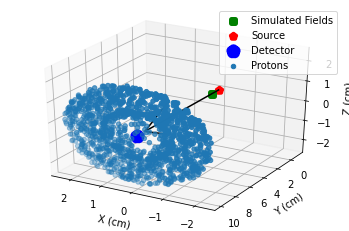

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.view_init(30,120)
ax.set_xlabel('X (cm)')
ax.set_ylabel('Y (cm)')
ax.set_zlabel('Z (cm)')

# Plot the source-to-detector axis
ax.quiver(sim.source[0].to(u.cm).value, 
          sim.source[1].to(u.cm).value,
          sim.source[2].to(u.cm).value,
          sim.detector[0].to(u.cm).value, 
          sim.detector[1].to(u.cm).value,
          sim.detector[2].to(u.cm).value, color='black')   

# Plot the simulation field grid volume
ax.scatter(0,0,0, color='green', marker='s', linewidth=5, label='Simulated Fields')

# Plot the the proton source and detector plane locations
ax.scatter(sim.source[0].to(u.cm).value, 
           sim.source[1].to(u.cm).value,
           sim.source[2].to(u.cm).value, color='red', marker='*', linewidth=5, label='Source')

ax.scatter(sim.detector[0].to(u.cm).value, 
           sim.detector[1].to(u.cm).value,
           sim.detector[2].to(u.cm).value, color='blue', marker='*', linewidth=10, label='Detector')


# Plot the final proton positions of some (not all) of the protons
ind = slice(None,None,300)
ax.scatter(sim.r[ind,0].to(u.cm).value, sim.r[ind,1].to(u.cm).value, sim.r[ind,2].to(u.cm).value, label='Protons')

ax.legend()

A 'synthetic proton radiograph' can then be constructed by creating a 2D histogram of proton positions in the image plane. The synthetic radiograph function takes two keywords:
- 'size' gives the locations of the lower left and upper right corners of the detector grid to be plotted in image plane coordinates.
- 'bins' is the number of histogram bins to be used in the horizontal and vertical directions. Using more bins creates a higher resolution image, but at the cost of more noise.

Text(0.5, 1.0, 'Synthetic Proton Radiograph')

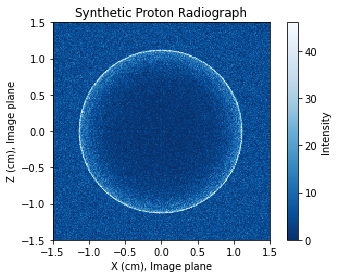

In [10]:
size = np.array([[-1,1],[-1,1]])*1.5*u.cm
bins = [200,200]
hax, vax, intensity = sim.synthetic_radiograph(size=size, bins=bins)

fig, ax = plt.subplots()
plot = ax.pcolormesh(hax.to(u.cm).value, vax.to(u.cm).value,
                     intensity.T, cmap='Blues_r')

cb = fig.colorbar(plot)
cb.ax.set_ylabel("Intensity")

ax.set_aspect('equal')
ax.set_xlabel('X (cm), Image plane')
ax.set_ylabel('Z (cm), Image plane')
ax.set_title("Synthetic Proton Radiograph")

As expected, the outward-pointing electric field in the sphere has deflected the protons out of the central region, leaving a dark shadow.

A number of other test fields are also available, some of which are included below.

## Cylindrical Axial Magnetic Field

In [11]:
grid, E, B = prad.example_fields(model='axial magnetic field', bmax=20*u.T, num=(200,200,200))

source = (-10*u.mm, 0*u.mm, 0*u.mm)
detector = (100*u.mm, 0*u.mm, 0*u.mm) 

sim = prad.SyntheticProtonRadiograph(grid, E, B, source, detector, 
                   proton_energy=14*u.MeV, geometry='cartesian', verbose=True)

sim.run(nparticles=5e5, max_theta = np.pi/12*u.rad)

Source: [-10.   0.   0.] mm
Detector: [100.   0.   0.] mm
Auto-detected a regularly spaced grid.
Creating regular grid interpolator
Creating Particles
0.0% on grid (0.0)
0.0% on grid (2)
9.1% on grid (16219)
18.3% on grid (32596)
27.4% on grid (48741)
36.6% on grid (65150)
45.8% on grid (81361)
53.8% on grid (95660)
58.3% on grid (103605)
61.0% on grid (108460)
62.7% on grid (111410)
63.5% on grid (112832)
63.6% on grid (113051)
63.4% on grid (112788)
63.3% on grid (112523)
63.1% on grid (112262)
63.0% on grid (112033)
62.9% on grid (111798)
62.7% on grid (111568)
62.6% on grid (111307)
62.5% on grid (111080)
62.3% on grid (110848)
62.2% on grid (110601)
62.1% on grid (110354)
61.9% on grid (110103)
61.8% on grid (109870)
61.7% on grid (109654)
61.5% on grid (109420)
61.4% on grid (109165)
61.2% on grid (108908)
61.1% on grid (108687)
61.0% on grid (108455)
60.9% on grid (108231)
60.7% on grid (108013)
60.6% on grid (107761)
60.5% on grid (107528)
60.3% on grid (107294)
60.2% on grid (

Text(0.5, 1.0, 'Synthetic Proton Radiograph')

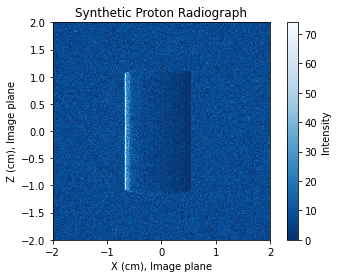

In [12]:
size = np.array([[-1,1],[-1,1]])*2*u.cm
bins = [200,200]
hax, vax, intensity = sim.synthetic_radiograph(size=size, bins=bins)

fig, ax = plt.subplots()
plot = ax.pcolormesh(hax.to(u.cm).value, vax.to(u.cm).value,
                     intensity.T, cmap='Blues_r')

cb = fig.colorbar(plot)
cb.ax.set_ylabel("Intensity")

ax.set_aspect('equal')
ax.set_xlabel('X (cm), Image plane')
ax.set_ylabel('Z (cm), Image plane')
ax.set_title("Synthetic Proton Radiograph")

## Cylindrically-symmetric planar electrostatic shock

This grid has an electrostatic discontinuity at z=0 and and a cylindrically-symmetric Gaussian profile in the x-y plane.

Text(0.5, 1.0, 'X=Y=0')

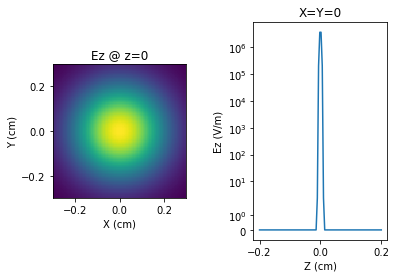

In [13]:
grid, E, B = prad.example_fields(model='electrostatic planar shock',
                              num=(100,100,100),
                              length=np.array([3,3,2])*u.mm,
                              emax=2e8*u.V/u.m)


fig, ax = plt.subplots(ncols=2)
fig.subplots_adjust(wspace=0.5)
xaxis, yaxis, zaxis = grid[:,0,0,0], grid[0,:,0,1], grid[0,0,:,2]

ax[0].pcolormesh(xaxis.to(u.cm).value, yaxis.to(u.cm).value, E[:,:,50, 2].value)
ax[0].set_aspect('equal')
ax[0].set_xlabel("X (cm)")
ax[0].set_ylabel("Y (cm)")
ax[0].set_title("Ez @ z=0")

ax[1].plot(zaxis.to(u.cm).value, E[0,0,:, 2].value)
ax[1].set_yscale('symlog')
ax[1].set_xlabel("Z (cm)")
ax[1].set_ylabel("Ez (V/m)")
ax[1].set_title("X=Y=0")

In [14]:
source = (-10*u.mm, 0*u.mm, 0*u.mm)
detector = (100*u.mm, 0*u.mm, 0*u.mm) 

sim = prad.SyntheticProtonRadiograph(grid, E, B, source, detector, 
                   proton_energy=14*u.MeV, geometry='cartesian', verbose=True)

sim.run(nparticles=6e5, max_theta = np.pi/14*u.rad)

Source: [-10.   0.   0.] mm
Detector: [100.   0.   0.] mm
Auto-detected a regularly spaced grid.
Creating regular grid interpolator
Creating Particles
0.0% on grid (0.0)
0.1% on grid (313)
34.2% on grid (205214)
67.9% on grid (407533)
100.0% on grid (600000)
100.0% on grid (600000)
100.0% on grid (600000)
100.0% on grid (600000)
100.0% on grid (600000)
100.0% on grid (600000)
100.0% on grid (600000)
100.0% on grid (600000)
100.0% on grid (600000)
100.0% on grid (600000)
100.0% on grid (600000)
100.0% on grid (600000)
100.0% on grid (600000)
100.0% on grid (600000)
100.0% on grid (600000)
100.0% on grid (600000)
100.0% on grid (600000)
100.0% on grid (600000)
100.0% on grid (600000)
100.0% on grid (600000)
100.0% on grid (600000)
100.0% on grid (600000)
100.0% on grid (600000)
100.0% on grid (600000)
100.0% on grid (600000)
100.0% on grid (600000)
100.0% on grid (600000)
100.0% on grid (600000)
100.0% on grid (600000)
100.0% on grid (600000)
100.0% on grid (599963)
99.9% on grid (599478

Text(0.5, 1.0, 'Synthetic Proton Radiograph')

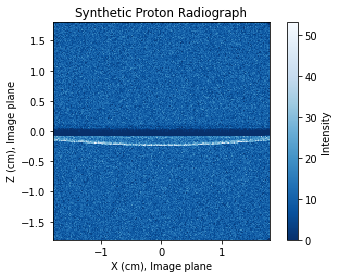

In [15]:
size = np.array([[-1,1],[-1, 1]])*1.8*u.cm
bins = [200,200]
hax, vax, intensity = sim.synthetic_radiograph(size=size, bins=bins)

fig, ax = plt.subplots()
plot = ax.pcolormesh(hax.to(u.cm).value, vax.to(u.cm).value,
                     intensity.T, cmap='Blues_r')

cb = fig.colorbar(plot)
cb.ax.set_ylabel("Intensity")

ax.set_aspect('equal')
ax.set_xlabel('X (cm), Image plane')
ax.set_ylabel('Z (cm), Image plane')
ax.set_title("Synthetic Proton Radiograph")

The bright band created in this radiograph is an example of a caustic: a non-linear effect which produces bands of very high intensity.